<H1 style="color:teal;"><p style="font-family:Georgia;"><B><I><Center>Automated ticketing system using sentimental analysis</center></B></H1>

<H3 style="color:navy;"><p style="font-family:Georgia;">Steps to be followed:</H3>
<ol style="font-family:Georgia;"><li>Data loading and understanding
<li> Data Cleaning
<li>Data preprocessing
<li>Data Visualization (EDA)
<li>Feature extraction
<li>Topic modelling
<li>Model building
<li>Model inference

<H3><p style="font-family:Georgia;"> Installing Libraries</p></H3>

In [1]:
!pip install textblob > nul 2>&1

In [2]:
pip install --upgrade textblob > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nltk > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade nltk > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install wordcloud > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install spacy -q > nul 2>&1
!python -m spacy download en_core_web_sm -q > nul 2>&1

In [7]:
pip install catboost > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


<H3><p style="font-family:Georgia;">Importing Libraries

In [8]:
# Libraries for data loading and manipulation
import pandas as pd
import numpy as np
import json
import pickle


# Libraries for data visualization and EDA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Libraries for text preprocessing
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
# from subprocess import check_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Libraries for machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [9]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
import string
import en_core_web_sm
nlp = en_core_web_sm.load()
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")

import nltk
nltk.download('averaged_perceptron_tagger', quiet=True)

True

<H3><p style="font-family:Georgia;">Data Loading and Understanding

In [11]:
data = pd.read_csv(r'....\complaint_data.csv')
data

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954
1,12/23/2019,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,NaN,NaN,AES/PHEAA,MA,019XX,NaN,NaN,Web,12/23/2019,Closed with explanation,Yes,NaN,3475943
2,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",NY,10801,NaN,Consent not provided,Web,01/30/2019,Closed with non-monetary relief,Yes,NaN,3136759
3,08/19/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,CA,94526,NaN,Consent not provided,Web,08/19/2015,Closed with explanation,Yes,No,1527601
4,03/04/2016,Credit card,NaN,Billing disputes,NaN,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471761,01/29/2016,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,Company believes it acted appropriately as aut...,American Financial Network Inc.,CA,91321,NaN,Consent not provided,Web,01/29/2016,Closed with monetary relief,Yes,No,1765368
1471762,11/27/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,NaN,NaN,"Diversified Consultants, Inc.",WI,531XX,NaN,NaN,Web,12/12/2019,Closed with explanation,Yes,NaN,3452575
1471763,05/07/2019,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"Hello, We were approved for a loan modificatio...",NaN,Ocwen Financial Corporation,CA,951XX,NaN,Consent provided,Web,05/07/2019,Closed with explanation,Yes,NaN,3235219
1471764,07/18/2019,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I started the process to refinance my current ...,Company has responded to the consumer and the ...,Freedom Mortgage Company,NC,275XX,NaN,Consent provided,Web,07/18/2019,Closed with explanation,Yes,NaN,3311105


In [12]:
# Randomly select 50000 rows from the dataset
data = data.sample(n=50000, random_state=42)

# Print the shape of the selected data to confirm it has 50000 rows
print(data.shape)

(50000, 18)


<p style="font-family:Georgia;">The reduced dataset now has 50,000 customer complaints and 18 features.
<p style="font-family:Georgia;">The customer complaint is in "Consumer complaint narrative" column

In [13]:
# Remove the leading underscores from all column names
data.columns = [re.sub('^_', '', col) for col in data.columns]
list(data.columns)

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

<p style="font-family:Georgia;"> Dropping the "Nan" values from "Consumer Complaint Narrative" column 

In [14]:
data.dropna(subset=['Consumer complaint narrative'], inplace=True)

In [15]:
## View first five rows of complaint column
data['Consumer complaint narrative'].head()

903961    I want to protect my families credit. \ni bein...
181768    Tidewater Finance Company, XXXX XXXX XXXX XXXX...
429107    While reviewing my XXXX, XXXX & XXXX credit re...
956042    Paypal is a horrible website to use, and a hor...
535043    I have a home mortgage with Provident Funding ...
Name: Consumer complaint narrative, dtype: object

<H2><p style="font-family:Georgia;">Data Preprocessing</H2>

<p style="font-family:Georgia;">The following preprocessing on the text of complaints:
<ol style="font-family:Georgia;"><li>Make the text lowercase
<li>Remove text in square brackets
<li>Remove punctuation
<li>Remove words containing numbers

In [16]:
# Function here to clean the text and remove all the unnecessary elements.
def clean_text(text):   
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [17]:
# Apply the above function to complaint column and make a new dataframe containing text-cleaned complaints
df_clean = pd.DataFrame(data['Consumer complaint narrative'].apply(lambda x: clean_text(x)))

# View first five rows of text-cleaned dataframe
df_clean.head()

,Consumer complaint narrative
903961,i want to protect my families credit \ni being...
181768,tidewater finance company xxxx xxxx xxxx xxxx ...
429107,while reviewing my xxxx xxxx xxxx credit repo...
956042,paypal is a horrible website to use and a horr...
535043,i have a home mortgage with provident funding ...


<p style="font-family:Georgia;">After performing cleaning operations, we do the following:
<ol style="font-family:Georgia;"><li>Lemmatize the texts
<li>Use POS tags to get relevant words from the texts.

In [18]:
#Write your function to Lemmatize the texts
def lemmatizer(text):     
    
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)

In [19]:
# Apply the function to the 'Consumer complaint narrative' column to create a new column 'lemmatized_complaint'
df_clean['lemmatized_complaint'] = df_clean['Consumer complaint narrative'].apply(lemmatizer)

# View the dataframe
print(df_clean.head())

                             Consumer complaint narrative  \
903961  i want to protect my families credit \ni being...   
181768  tidewater finance company xxxx xxxx xxxx xxxx ...   
429107  while reviewing my xxxx xxxx  xxxx credit repo...   
956042  paypal is a horrible website to use and a horr...   
535043  i have a home mortgage with provident funding ...   

                                     lemmatized_complaint  
903961  I want to protect my family credit \n I be the...  
181768  tidewater finance company xxxx xxxx xxxx xxxx ...  
429107  while review my xxxx xxxx   xxxx credit report...  
956042  paypal be a horrible website to use and a horr...  
535043  I have a home mortgage with provident funding ...  


In [20]:
# Add a column for lemmatized complaints to the dataframe
df_clean["Consumer complaint narrative"] =  df_clean.apply(lambda x: lemmatizer(x['Consumer complaint narrative']), axis=1)

# View the dataframe
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...


<p style="font-family:Georgia;">We will use Chunking to extract singular nouns from the lemmatized complaints

<p style="font-family:Georgia;"> We extract only nouns because we are interested in finding topics, which are mostly nouns

In [21]:
# Extract singular nouns
def get_singular_nouns(text):
    
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 
# We don't have plural nouns as the text is already lemmatized
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...,review credit report collection profile xxxx d...
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...,website service issue website everything inves...
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...,home mortgage funding issue service process re...


<H2><p style="font-family:Georgia;"> Data Visualisation</H2>

<p style="font-family:Georgia;"> Here, we do the following steps of Exploratory Data Analysis (EDA) to get familiar with the data.
<ul style="font-family:Georgia;">Visualise the data according to the 'Complaint' character length
<ul style="font-family:Georgia;">Using a word cloud find the top 40 words by frequency among all the articles after processing the text
<ul style="font-family:Georgia;">Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
# Create list of lengths of pre-processed complaints
doc_lens = [len(d) for d in df_clean['Consumer complaint narrative']]
doc_lens[:5]

[1110, 373, 971, 1052, 2230]

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

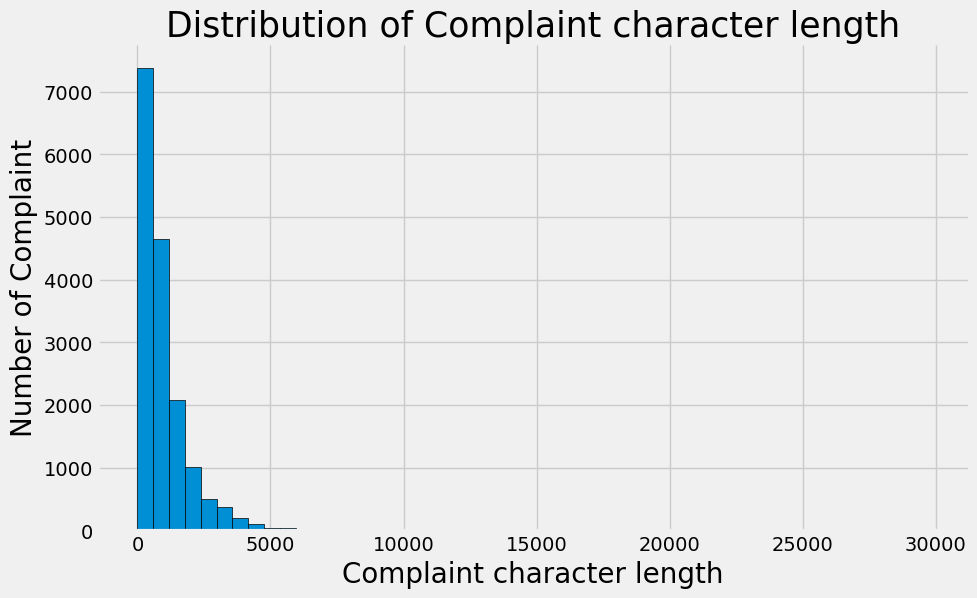

In [24]:
# Plot the data according to character length of complaints
plt.figure(figsize=(10,6))
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=25)
plt.ylabel('Number of Complaint', fontsize=20)
plt.xlabel('Complaint character length', fontsize=20)
sns.despine()
plt.show()

<p style="font-family:Georgia;"> The distribution of word counts is skewed a little positie but overall it is a pretty mormal distribution.

<p style="font-family:Georgia;"> Now we plot top 40 words

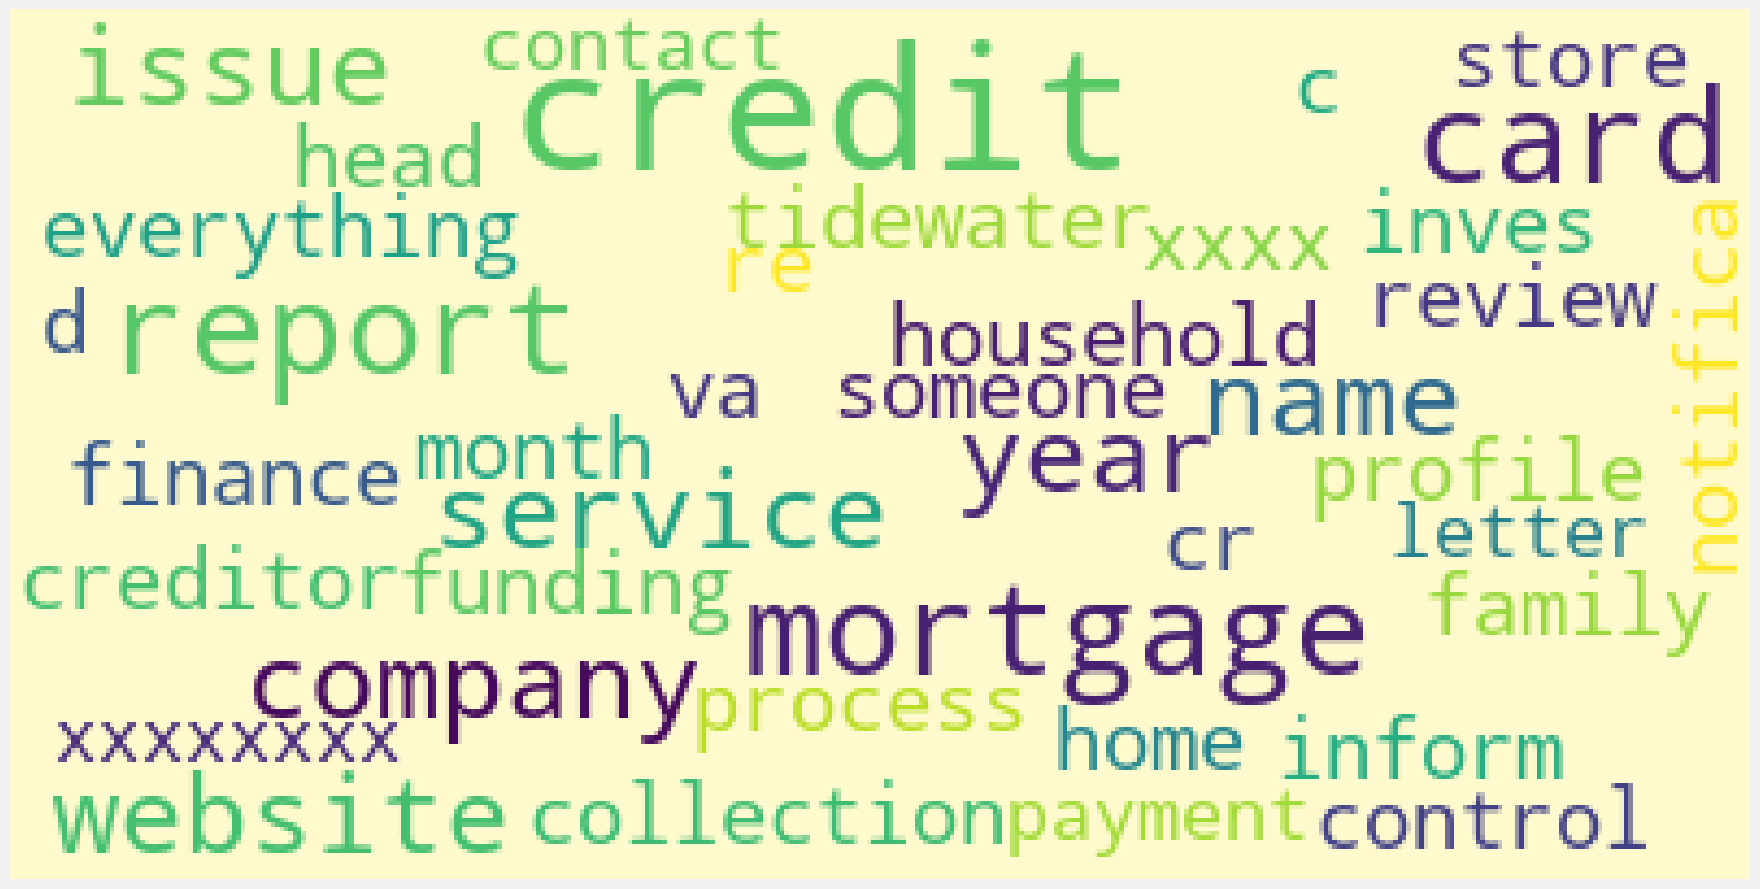

In [25]:
#Using a word cloud, we plot the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Consumer complaint narrative'] = df_clean['Consumer complaint narrative'].str.replace('-PRON-', '')

In [27]:
# We now find the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

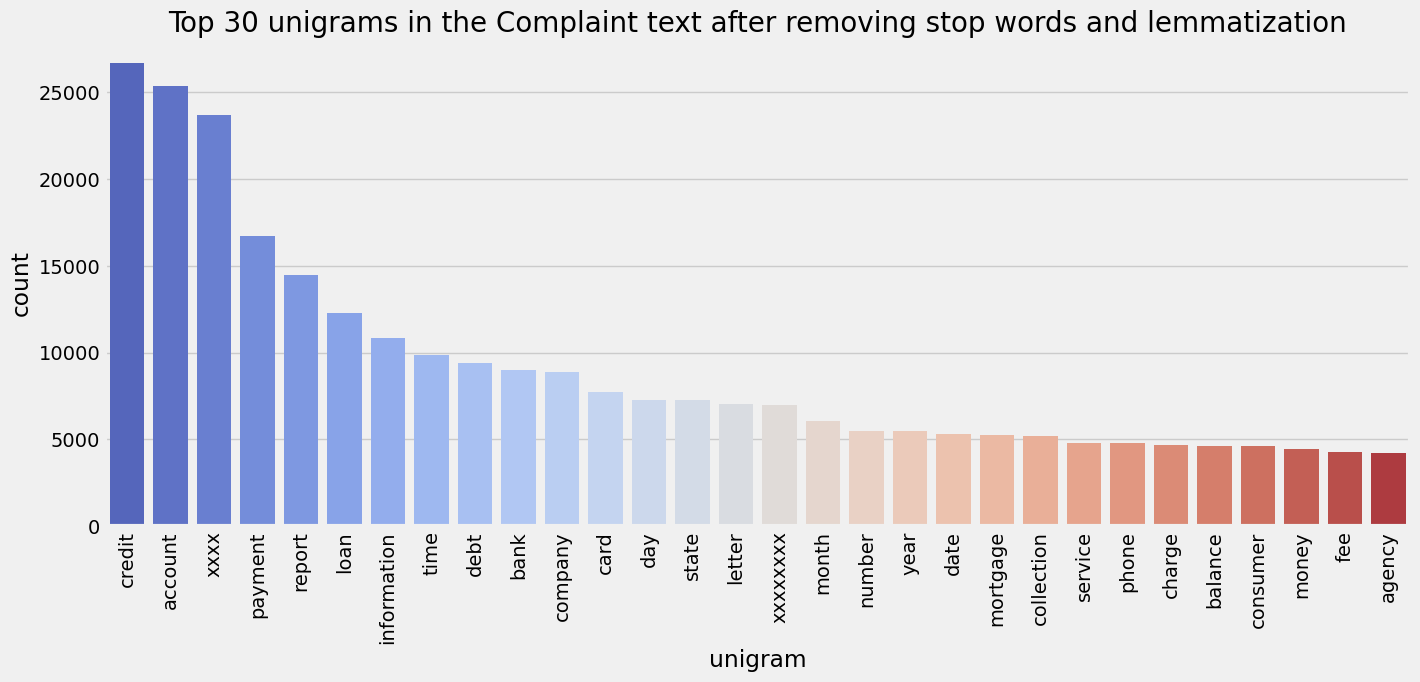

In [28]:
# Top 30 unigrams by frequency among all the complaints
common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [29]:
# View top 10 unigrams
df2.head(10)

,unigram,count
0,credit,26676
1,account,25389
2,xxxx,23682
3,payment,16747
4,report,14477
5,loan,12272
6,information,10827
7,time,9843
8,debt,9406
9,bank,8992


<p style="font-family:Georgia;"> Next, we find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text

In [30]:
# We now find the top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

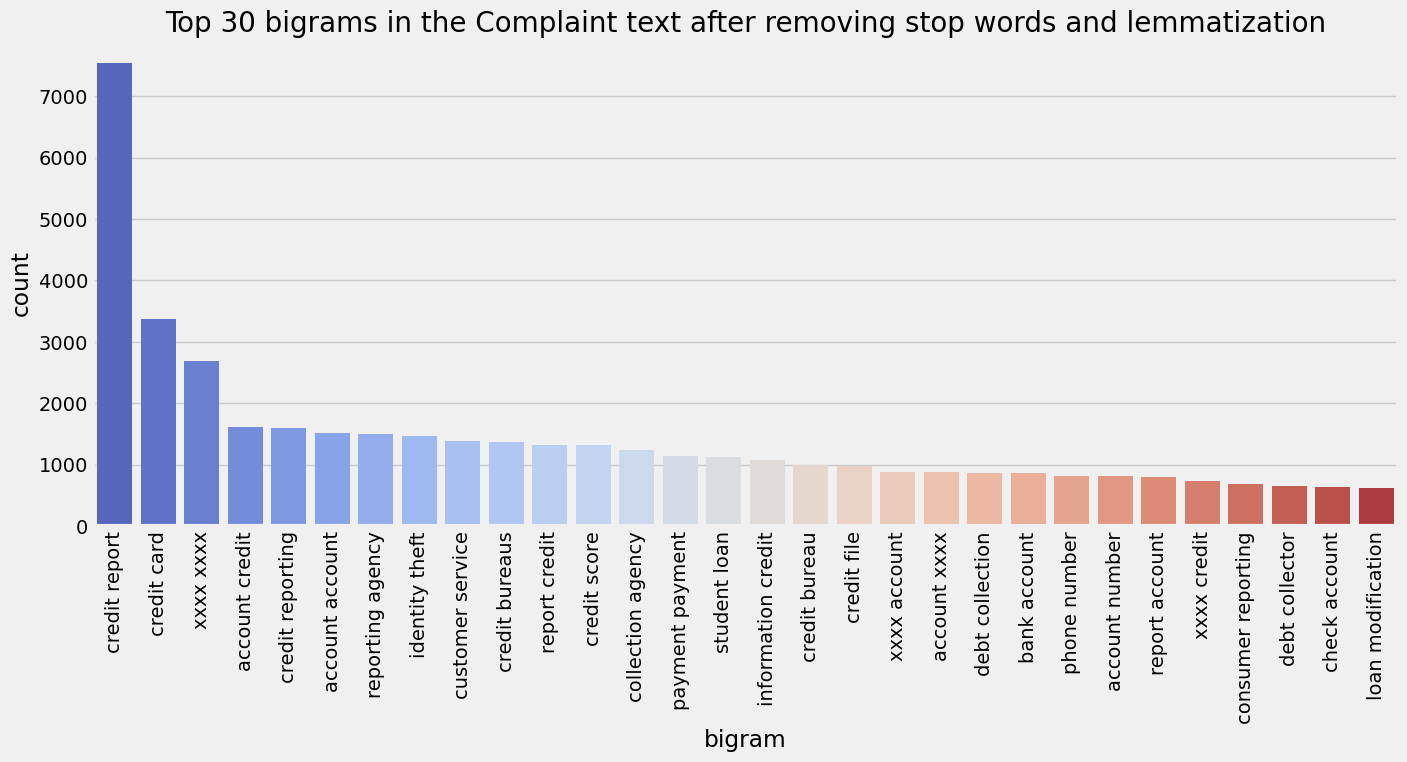

In [31]:
# Top 30 bigrams by frequency among all the complaints
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [32]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,credit report,7537
1,credit card,3364
2,xxxx xxxx,2691
3,account credit,1611
4,credit reporting,1593
5,account account,1508
6,reporting agency,1497
7,identity theft,1460
8,customer service,1393
9,credit bureaus,1375


In [33]:
# We now find the top 30 trigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

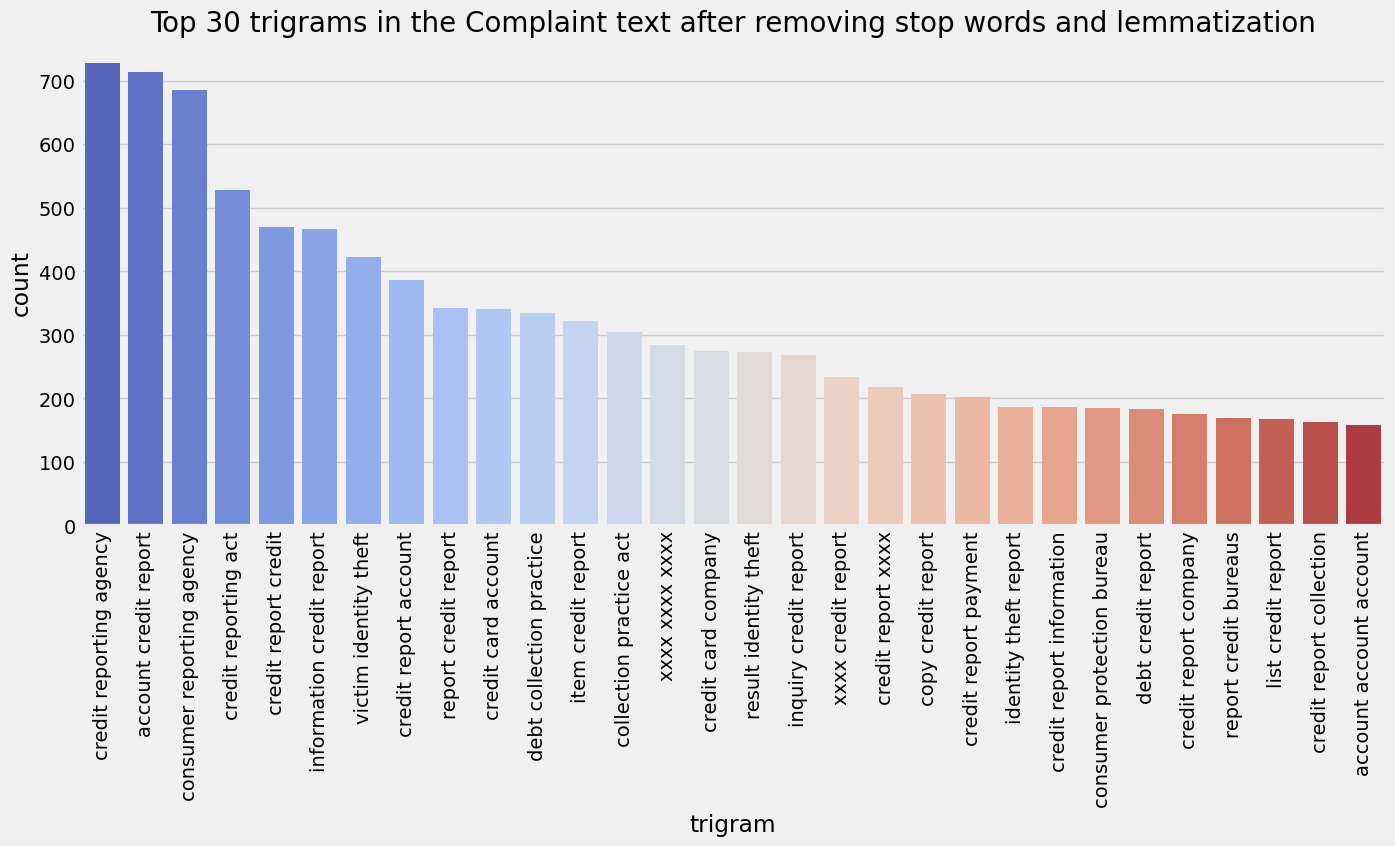

In [34]:
# Top 30 trigrams by frequency among all the complaints
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [35]:
# Print the top 10 words in the trigram frequency
df4.head(10)

,trigram,count
0,credit reporting agency,728
1,account credit report,713
2,consumer reporting agency,685
3,credit reporting act,528
4,credit report credit,470
5,information credit report,467
6,victim identity theft,423
7,credit report account,387
8,report credit report,342
9,credit card account,340


<p style="font-family:Georgia;"> The personal details of customer has been masked in the dataset with xxxx.

<p style="font-family:Georgia;"> We will remove the masked text as this will be of no use for our analysis.

In [36]:
# Remove masks 'xxxx' from complaints
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [37]:
# View final pre-processed data
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...,review credit report collection profile debt ...
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...,website service issue website everything inves...
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...,home mortgage funding issue service process re...


<H2><p style="font-family:Georgia;">Feature Extraction</H2>

<p style="font-family:Georgia;">Now, we convert the raw texts to a matrix of TF-IDF features
<ol style="font-family:Georgia;"> We use following parameters of TfidfVectorizer:-

<li>max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

<li>min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

<ol style="font-family:Georgia;">Next, we create a document term matrix using fit_transform¶
<li>The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
<li>The tuples that are not there have a tf-idf score of 0

In [39]:
# Create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

<H2><p style="font-family:Georgia;">Topic Modelling</H2>
<ol style="font-family:Georgia;">We now perform Topic Modelling using NMF¶
<li>Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.</ol>
<ol style="font-family:Georgia;">We will perform the following steps:
<li>Find the best number of clusters/topics
<li>Apply the best number to create word clusters/topics
<li>Inspect & validate the correction of each cluster for each complaint
<li>Correct the labels if needed
<li>Map the clusters to topics/cluster names

<ol style="font-family:Georgia;"><B>To select best number of Topics, we will use Coherence Model</B>
<li>With the Coherence Model we will see how to automatically select the best number of topics.

In [40]:
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


<ol style="font-family:Georgia;">Manual Topic Modeling
<li>With the Coherence Model we got the best number of topics = 5.

<li>The hard work is already done at this point so all we need to do is run the model.

<li>The only parameter that is required is the number of components i.e. the number of topics we want.

<li>This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
# Load nmf_model with the n_components set to 5
nmf_model = NMF(n_components=5, random_state=40)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
!pip3 install catboost > nul 2>&1

In [44]:
# Fit the model on document term matrix
nmf_model.fit(dtm)

# View the number of features
len(tfidf.get_feature_names())

5993

In [45]:
# Get the top 10 word indices for the first topic
top_word_indices = nmf_model.components_[0].argsort()[-10:]

# Print the top 10 words for the first topic
for i in top_word_indices:
    print(tfidf.get_feature_names()[i])

company
transunion
bureaus
identity
reporting
item
information
inquiry
report
credit


In [46]:
# Print the Top 15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')


THE TOP 15 WORDS FOR TOPIC #0
['dispute', 'theft', 'score', 'equifax', 'file', 'company', 'transunion', 'bureaus', 'identity', 'reporting', 'item', 'information', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC #1
['pay', 'rate', 'statement', 'date', 'company', 'modification', 'day', 'home', 'student', 'year', 'time', 'month', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #2
['law', 'creditor', 'proof', 'information', 'contract', 'phone', 'collector', 'number', 'state', 'validation', 'agency', 'letter', 'company', 'collection', 'debt']


THE TOP 15 WORDS FOR TOPIC #3
['check', 'knowledge', 'list', 'proof', 'payment', 'pay', 'status', 'date', 'file', 'creditor', 'dispute', 'number', 'collection', 'balance', 'account']


THE TOP 15 WORDS FOR TOPIC #4
['fraud', 'number', 'service', 'phone', 'transaction', 'customer', 'time', 'day', 'check', 'money', 'credit', 'fee', 'charge', 'bank', 'card']




In [47]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 0, 2, ..., 4, 1, 0], dtype=int64)

In [48]:
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_results.argmax(axis=1)

# View the feature matrix
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed,Topic
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...,0
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...,0
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...,review credit report collection profile debt ...,2
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...,website service issue website everything inves...,4
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...,home mortgage funding issue service process re...,4


In [49]:
# Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)

df_clean5.sort_values('Topic')

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed,Topic
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...,0
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...,0
193287,capital one have violate x usc by continue...,capital one have violate x usc by continue...,capital violate collection activity cease desi...,0
1431887,santander have violate usc by continue col...,santander have violate usc by continue col...,santander collection activity cease desist fai...,0
1296013,on I go to look at new vehicle at xxxx xxxx ...,on I go to look at new vehicle at xxxx xxxx ...,vehicle tx salesman i d order vehicle vehicle ...,0
266815,in xxxx I obtain a negativeamortization loan f...,in xxxx I obtain a negativeamortization loan f...,negativeamortization loan wamu property tax in...,1
1232707,file an investigation regard number of qualify...,file an investigation regard number of qualify...,file investigation regard number payment servi...,1
827143,I be currently make payment to automobile acce...,I be currently make payment to automobile acce...,payment acceptance corporation fall day paymen...,1
655509,I be be call multiple time on my cell phone an...,I be be call multiple time on my cell phone an...,time cell phone home phone student loan colle...,1
833378,I call calliber customer care department xxxx ...,I call calliber customer care department xxxx ...,customer care department speak surprise modi...,1


<ol style="font-family:Georgia;"><B>After looking carefully at the first 5 complaints for each topics, we can assign names to topics as below</B>
<li>Topic 0: Bank Account services
<li>Topic 1: Credit card or prepaid card
<li>Topic 2: Others
<li>Topic 3: Theft/Dispute Reporting
<li>Topic 4: Mortgage/Loan

<p style="font-family:Georgia;">We create a dictionary and map the above names to the 5 topics

In [50]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [51]:
# View the feature matrix
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed,Topic
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...,Bank Account services
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...,Bank Account services
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...,review credit report collection profile debt ...,Others
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...,website service issue website everything inves...,Mortgage/Loan
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...,home mortgage funding issue service process re...,Mortgage/Loan


<H2><p style="font-family:Georgia;"><B>Model Building</H2>

<ul style="font-family:Georgia;">
<li>💠 Now that we have a label column, we can build Supervised model to predict any new complaints and assign them the relevant Topic.
<li>💠 Since we will be using supervised learning technique, we have to convert the topic names to numbers (numpy arrays only understand numbers

In [52]:
# Create the dictionary again of Topic names and Topic numbers
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

# View the dataframe
df_clean.head()

,Consumer complaint narrative,lemmatized_complaint,complaint_POS_removed,Topic
903961,I want to protect my family credit \n I be the...,I want to protect my family credit \n I be the...,family credit head household inform control cr...,0
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company xxxx xxxx xxxx xxxx ...,tidewater finance company va creditor report c...,0
429107,while review my xxxx xxxx xxxx credit report...,while review my xxxx xxxx xxxx credit report...,review credit report collection profile debt ...,2
956042,paypal be a horrible website to use and a horr...,paypal be a horrible website to use and a horr...,website service issue website everything inves...,4
535043,I have a home mortgage with provident funding ...,I have a home mortgage with provident funding ...,home mortgage funding issue service process re...,4


<ul style="font-family:Georgia;">
💠Now that we have assigned a topic to each complaint, we can select these two columns as our training data

In [53]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["Consumer complaint narrative","Topic"]]

# View the training data
training_data.head()

,Consumer complaint narrative,Topic
903961,I want to protect my family credit \n I be the...,0
181768,tidewater finance company xxxx xxxx xxxx xxxx ...,0
429107,while review my xxxx xxxx xxxx credit report...,2
956042,paypal be a horrible website to use and a horr...,4
535043,I have a home mortgage with provident funding ...,4


In [54]:
# View dimensions of training data
training_data.shape

(16484, 2)

<p style="font-family:Georgia;">💠 View the distribution of target variable Topic

In [55]:
# View value counts of the five topics
training_data['Topic'].value_counts()

1    4207
0    3506
4    3431
2    2959
3    2381
Name: Topic, dtype: int64

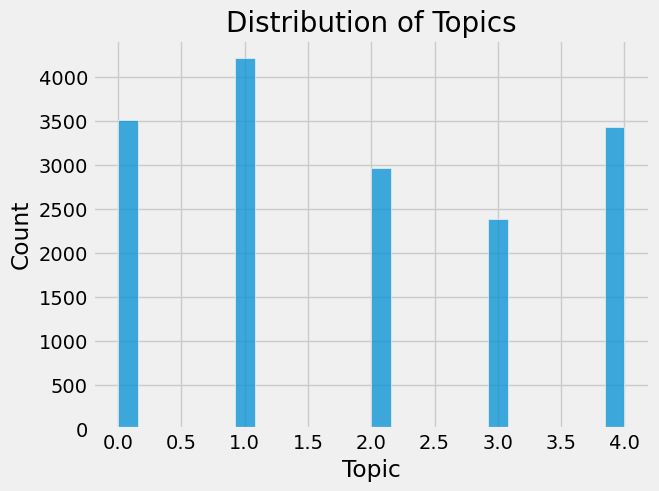

In [56]:
# Plot a histogram of classes (i.e. topics)
sns.histplot(data=training_data, x='Topic')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

<ol style="font-family:Georgia;">💠 Selection of Evaluation Metric
<li>As the distribution of target variable is not normal and there is imbalance of classes, we select F1 Score as our evaluation metric for comparing the performance of various models we will build.
<li>Moreover, we will use a weighted average method for evaluating F1 Score due to the imbalance of classes

<ol style="font-family:Georgia;">💠 We can now apply the supervised models on the training data created.
In this process, we will do the following:</ol>
<ol style="font-family:Georgia;"><li>Create the vector counts using Count Vectorizer
<li>Transform the word vector to tf-idf
<li>Create the train & test data using the train_test_split on the tf-idf & topics

In [57]:
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['Consumer complaint narrative'])

In [58]:
# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [59]:
# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [60]:
# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [61]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, training_data.Topic)
X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.20, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.20, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (16828, 22487)
Shape of y_train: (16828,)
Shape of X_test: (4207, 22487)
Shape of y_test: (4207,)


<ol style="font-family:Georgia;">💠Now, we will try the following models one by one and evaluate them to select the best performing one
<li>Random Forest
<li>Support Vector Machine
<li>Decision Tree

<p style="font-family:Georgia;">💠 Create a function to evaluate the classifiers

In [62]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

<H2><p style="font-family:Georgia;"><B>Model 1: Random Forest</B></H2>

In [63]:
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

Wall time: 0 ns


In [64]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8696295483541726

In [65]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

Wall time: 0 ns


In [66]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.881114307331284

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.88      0.85      0.86       854
Credit card or prepaid card       0.87      0.89      0.88       835
                     Others       0.90      0.91      0.90       841
    Theft/Dispute Reporting       0.89      0.92      0.90       839
              Mortgage/Loan       0.87      0.84      0.86       838

                   accuracy                           0.88      4207
                  macro avg       0.88      0.88      0.88      4207
               weighted avg       0.88      0.88      0.88      4207



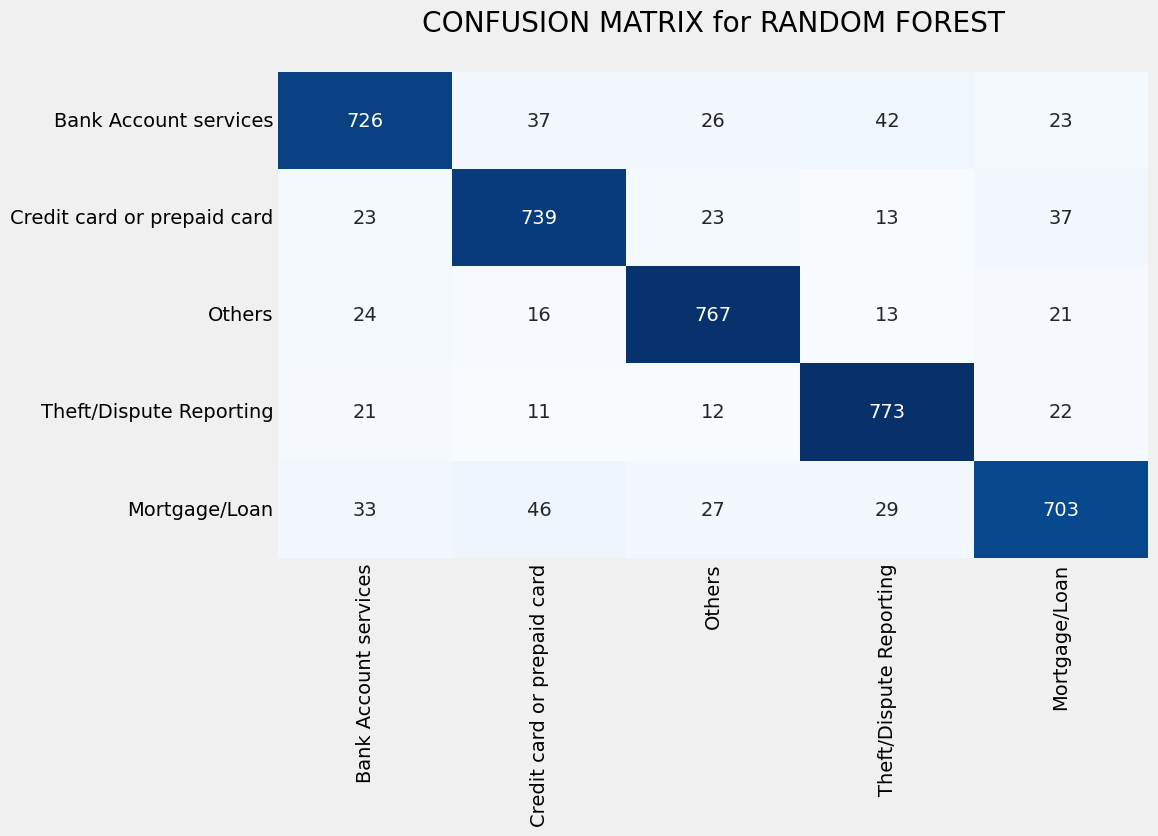

In [67]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

<p style="font-family:Georgia;">Create a summary table to store and compare F1 Scores of all model

In [68]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Random Forest','F1 Score (untuned)': round(f1_rf, 2), 'F1 Score (tuned)': round(f1_rf_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Random Forest,0.87,0.88


<H2><p style="font-family:Georgia;"><B>Model 2: Support Vector Machine</B></H2>

In [69]:
# Run the Support Vector Machine (SVM) model on default hyperparameters
model_name = 'SUPPORT VECTOR MACHINE'
clf_svm = SVC()
%time 
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

Wall time: 0 ns


In [70]:
# Calculate F1 Score using weighted average method
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
f1_svm

0.9379789939189416

In [71]:
# Run SVM on tuned hyperparameters
clf_svm_tuned = SVC(C=10,
                    gamma='scale',
                    kernel='rbf')
%time 
clf_svm_tuned.fit(X_train, y_train)
y_pred_svm_tuned = clf_svm_tuned.predict(X_test)

Wall time: 0 ns


In [72]:
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average="weighted")
f1_svm_tuned

0.9448563189716427

CLASSIFICATION REPORT for SUPPORT VECTOR MACHINE

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.94      0.94       854
Credit card or prepaid card       0.95      0.95      0.95       835
                     Others       0.95      0.95      0.95       841
    Theft/Dispute Reporting       0.95      0.95      0.95       839
              Mortgage/Loan       0.94      0.93      0.93       838

                   accuracy                           0.94      4207
                  macro avg       0.94      0.94      0.94      4207
               weighted avg       0.94      0.94      0.94      4207



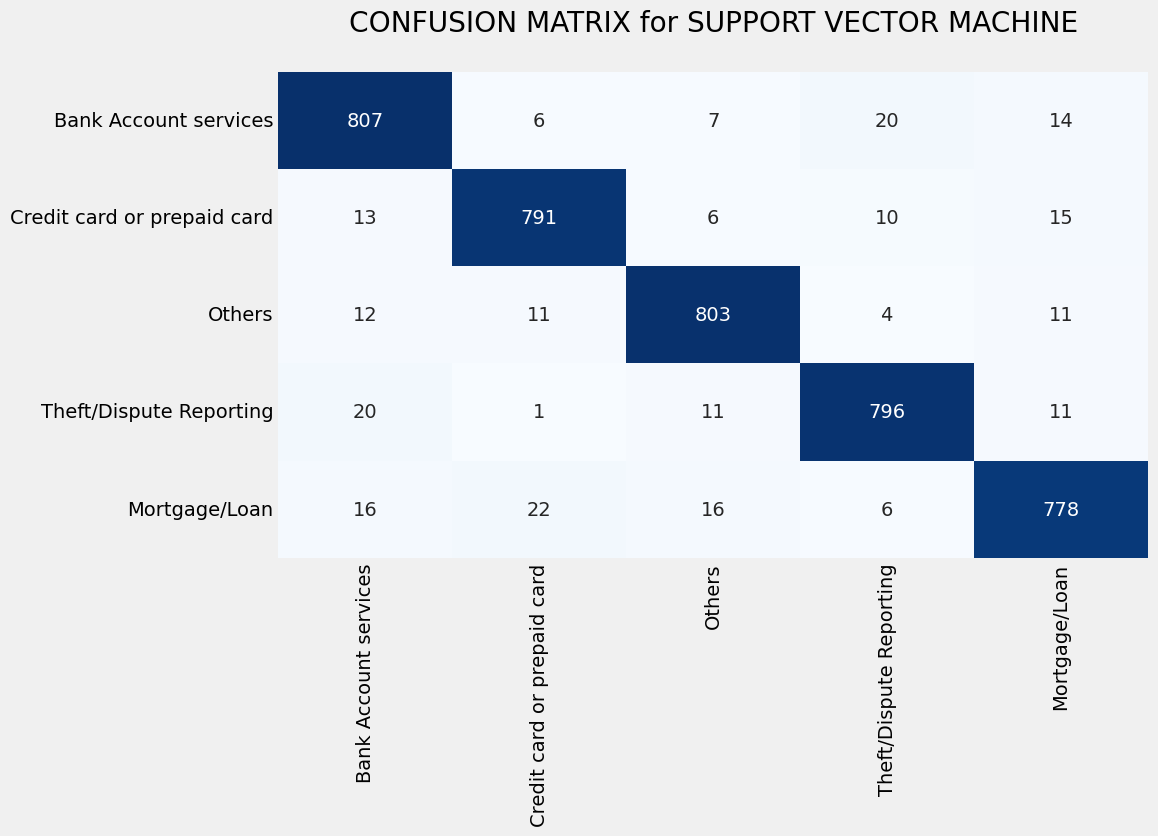

In [73]:
# Evaluate the SVM classifier
eval_model(y_test, y_pred_svm_tuned, model_name)

In [74]:
# Update the summary table
summary.loc[len(summary.index)] = ['Support Vector Machine', round(f1_svm, 2), round(f1_svm_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Random Forest,0.87,0.88
1,Support Vector Machine,0.94,0.94


<H2><p style="font-family:Georgia;"><B>Model 3: Decision Tree</B></H2>

In [75]:
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

Wall time: 0 ns


In [76]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.8391473023925015

In [77]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

Wall time: 0 ns


In [78]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.8379880229748049

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.83      0.82       854
Credit card or prepaid card       0.84      0.87      0.85       835
                     Others       0.86      0.86      0.86       841
    Theft/Dispute Reporting       0.85      0.87      0.86       839
              Mortgage/Loan       0.81      0.76      0.79       838

                   accuracy                           0.84      4207
                  macro avg       0.84      0.84      0.84      4207
               weighted avg       0.84      0.84      0.84      4207



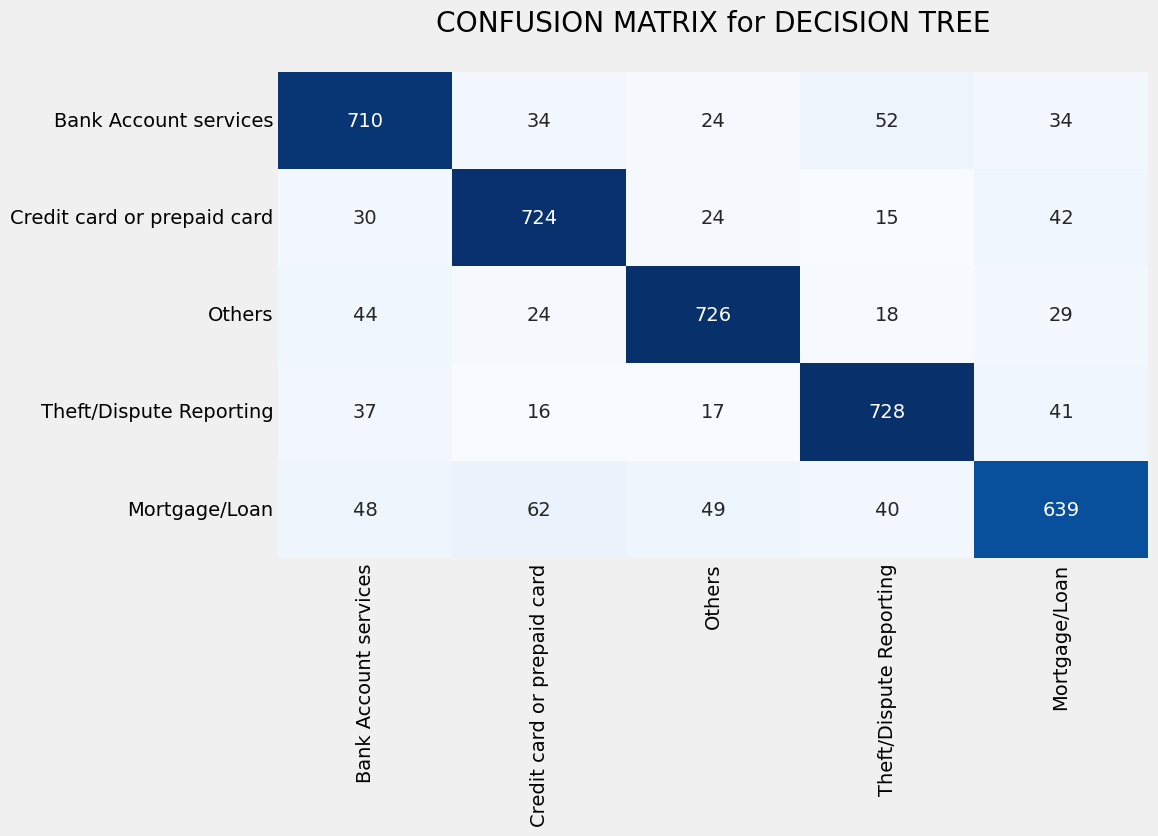

In [79]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

In [80]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Random Forest,0.87,0.88
1,Support Vector Machine,0.94,0.94
2,Decision Tree,0.84,0.84


<p style="font-family:Georgia;">From the above summary table, we observe that the tuned SVM performs the best among all that we tried.

In [85]:
def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))
    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [86]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


<p style="font-family:Georgia;"><B>Thus, we can conclude that our model performs very well in classifying any new text.</B>